In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [5]:
from Bio import AlignIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [7]:
#pip install tensorflow


In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [11]:
alignment = AlignIO.read("combined.fa", "fasta")

data = {record.id: list(record.seq) for record in alignment}

df = pd.DataFrame(data).T # Transpose so rows = sequences

#df.to_csv("combined_proteins1.csv")

In [13]:
print("Loaded alignment:")
print("  Number of records:", len(alignment))

Loaded alignment:
  Number of records: 577


In [16]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
AEB89955,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89954,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89947,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89944,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89939,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [18]:
df.tail()


,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
QDR49873,M,K,T,I,I,A,L,S,H,I,...,-,-,-,-,-,-,-,-,-,-
QDR49878,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-
QDR49879,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-
QDR49899,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-
QDR49860,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-


In [20]:
df.shape

(577, 581)

In [22]:
df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
576    0
577    0
578    0
579    0
580    0
Length: 581, dtype: int64

In [24]:
df.index

Index(['AEB89955', 'AEB89954', 'AEB89947', 'AEB89944', 'AEB89939', 'AEB89934',
       'AGY42011', 'AEB89923', 'AEB89927', 'AEB89919',
       ...
       'QDR49868', 'QDR49871', 'QDR49903', 'QDR49880', 'QDR49898', 'QDR49873',
       'QDR49878', 'QDR49879', 'QDR49899', 'QDR49860'],
      dtype='object', length=577)

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
AEB89955,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89954,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89947,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89944,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
AEB89939,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QDR49873,M,K,T,I,I,A,L,S,H,I,...,-,-,-,-,-,-,-,-,-,-
QDR49878,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-
QDR49879,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-
QDR49899,M,K,T,I,I,A,L,S,Y,I,...,-,-,-,-,-,-,-,-,-,-


In [28]:
# Checking full and partial sequences

full_ids = []
partial_ids = []

for record in alignment:
    seq = str(record.seq)

    if (seq[1] == '-') or (seq[-1] == '-'):
        partial_ids.append(record.id)
    else:
        full_ids.append(record.id)

print("\nSequence type counts:")
print("  Full-length sequences    :", len(full_ids))
print("  Partial / truncated seqs :", len(partial_ids))


Sequence type counts:
  Full-length sequences    : 126
  Partial / truncated seqs : 451


In [30]:
# making dataset with full sequence only
data_full = {record.id: list(record.seq)
             for record in alignment if record.id in full_ids}

df = pd.DataFrame(data_full).T

print("\nDF_full shape:", df.shape)
print(df.head())


DF_full shape: (126, 581)
         0   1   2   3   4   5   6   7   8   9    ... 571 572 573 574 575 576  \
ADC32435   M   K   A   I   L   -   -   -   -   -  ...   N   G   S   L   Q   C   
AHF20373   M   N   T   Q   I   -   -   -   -   -  ...   N   G   N   M   R   C   
AHW83226   M   K   T   V   I   A   L   S   Y   V  ...   K   G   N   I   R   C   
WCJ17257   M   K   T   I   I   A   L   S   N   I  ...   K   G   N   I   R   C   
WCJ15754   M   K   T   I   I   A   L   S   N   I  ...   K   G   N   I   R   C   

         577 578 579 580  
ADC32435   R   I   C   I  
AHF20373   T   I   C   I  
AHW83226   N   I   C   I  
WCJ17257   N   I   C   I  
WCJ15754   N   I   C   I  

[5 rows x 581 columns]


In [32]:
df

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
ADC32435,M,K,A,I,L,-,-,-,-,-,...,N,G,S,L,Q,C,R,I,C,I
AHF20373,M,N,T,Q,I,-,-,-,-,-,...,N,G,N,M,R,C,T,I,C,I
AHW83226,M,K,T,V,I,A,L,S,Y,V,...,K,G,N,I,R,C,N,I,C,I
WCJ17257,M,K,T,I,I,A,L,S,N,I,...,K,G,N,I,R,C,N,I,C,I
WCJ15754,M,K,T,I,I,A,L,S,N,I,...,K,G,N,I,R,C,N,I,C,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALX28929,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
ALX28923,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
ALX28928,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I
ALX28501,M,K,T,I,I,A,L,S,Y,I,...,K,G,N,I,R,C,N,I,C,I


In [34]:
df.index

Index(['ADC32435', 'AHF20373', 'AHW83226', 'WCJ17257', 'WCJ15754', 'WCJ17233',
       'WCJ15742', 'WCB23671', 'WBR76700', 'WBR77162',
       ...
       'ALX28925', 'ALX28922', 'ALX28506', 'ALX28926', 'ALX28502', 'ALX28929',
       'ALX28923', 'ALX28928', 'ALX28501', 'ALX28503'],
      dtype='object', length=126)

In [36]:
#encoding = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')
#onehot_encoded = encoding.fit_transform(df)

In [38]:
#onehot_encoded

,x0_M,x1_K,x1_N,x2_A,x2_T,x3_I,x3_Q,x3_V,x4_I,x4_L,...,x575_Q,x575_R,x576_C,x577_N,x577_R,x577_T,x578_I,x578_V,x579_C,x580_I
ADC32435,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
AHF20373,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
AHW83226,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
WCJ17257,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
WCJ15754,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALX28929,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
ALX28923,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
ALX28928,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
ALX28501,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0


In [40]:
#onehot_encoded.to_csv("onehot1.csv")

In [43]:
# dummy
df = df.astype(str)


AA20 = list("ACDEFGHIKLMNPQRSTVWY")
CATS = AA20 + ["-"]          

n_pos = df.shape[1]

enc = OneHotEncoder(
    categories=[CATS]*n_pos,
    handle_unknown="ignore",
    sparse_output=False
).set_output(transform="pandas")

ohe = enc.fit_transform(df)


cols = [f"pos{j:03d}_{aa}" for j in range(n_pos) for aa in CATS]
ohe.columns = cols
#584 sequences
print(ohe.shape)


(126, 12201)


In [45]:
ohe.head()

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos580_N,pos580_P,pos580_Q,pos580_R,pos580_S,pos580_T,pos580_V,pos580_W,pos580_Y,pos580_-
ADC32435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHF20373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WCJ17257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WCJ15754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
ohe

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos580_N,pos580_P,pos580_Q,pos580_R,pos580_S,pos580_T,pos580_V,pos580_W,pos580_Y,pos580_-
ADC32435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHF20373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WCJ17257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WCJ15754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALX28929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALX28923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALX28928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALX28501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
ohe.shape

(126, 12201)

In [60]:
# reading header
original_dataset = "FASTA.fa"
headers = []
with open(original_dataset) as f:
    for line in f:
        if line.startswith(">"):
            headers.append(line.strip())

In [62]:
headers[:5]

['>ADC32435 A/Ancona/01/2010 2010/01/09 HA',
 '>WAB60448 A/Friuli-Venezia Giulia/USAFSAM-13464/2022 2022/09/27 HA',
 '>WBR18354 A/Friuli-Venezia Giulia/USAFSAM-13527/2022 2022/10/17 HA',
 '>WBR18633 A/Friuli-Venezia Giulia/USAFSAM-13528/2022 2022/10/17 HA',
 '>WBR77138 A/Friuli-Venezia Giulia/USAFSAM-13590/2022 2022/10/26 HA']

In [64]:
years = []
#head_name = []
for h in headers:
    y = h.split()[-2]
    year = int(y.split('/')[0])
    years.append(year)
    #head_name.append(y)
    

In [66]:
#head_name #testing
#years

In [68]:
ids = [h.split()[0].replace(">", "") for h in headers]

df_id_y = pd.DataFrame({
    "Id": ids,
    "Year": years
})

print(df_id_y.head())
print("Total IDs:", len(df_id_y))


         Id  Year
0  ADC32435  2010
1  WAB60448  2022
2  WBR18354  2022
3  WBR18633  2022
4  WBR77138  2022
Total IDs: 577


In [70]:
year_map = df_id_y.set_index("Id")["Year"]
print("Year map length:", len(year_map))

Year map length: 577


In [72]:
print("ohe shape:", ohe.shape)
print("Example index:", ohe.index[:5])

# Add Year column using the Id → Year map
ohe_yr = ohe.copy()
ohe_yr["Year"] = ohe_yr.index.to_series().map(year_map)

print("ohe_yr shape:", ohe_yr.shape)
print("Missing years:", ohe_yr["Year"].isna().sum())
print(ohe_yr[["Year"]].head())


ohe shape: (126, 12201)
Example index: Index(['ADC32435', 'AHF20373', 'AHW83226', 'WCJ17257', 'WCJ15754'], dtype='object')
ohe_yr shape: (126, 12202)
Missing years: 0
          Year
ADC32435  2010
AHF20373  2013
AHW83226  2014
WCJ17257  2022
WCJ15754  2022


In [74]:
len_full_ids = len(full_ids)
print("Number of full_ids:", len_full_ids)

mask_full = ohe_yr.index.isin(full_ids)
ohe_full = ohe_yr[mask_full].copy()

print("ohe_full shape:", ohe_full.shape)
print(ohe_full[["Year"]].head())


Number of full_ids: 126
ohe_full shape: (126, 12202)
          Year
ADC32435  2010
AHF20373  2013
AHW83226  2014
WCJ17257  2022
WCJ15754  2022


In [76]:
ohe_full

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos580_P,pos580_Q,pos580_R,pos580_S,pos580_T,pos580_V,pos580_W,pos580_Y,pos580_-,Year
ADC32435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010
AHF20373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
WCJ17257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022
WCJ15754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALX28929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
ALX28923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
ALX28928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
ALX28501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014


In [79]:
ohe_yr = ohe_full.copy()

In [81]:
ohe_yr

,pos000_A,pos000_C,pos000_D,pos000_E,pos000_F,pos000_G,pos000_H,pos000_I,pos000_K,pos000_L,...,pos580_P,pos580_Q,pos580_R,pos580_S,pos580_T,pos580_V,pos580_W,pos580_Y,pos580_-,Year
ADC32435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010
AHF20373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
AHW83226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
WCJ17257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022
WCJ15754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ALX28929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
ALX28923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
ALX28928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
ALX28501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014


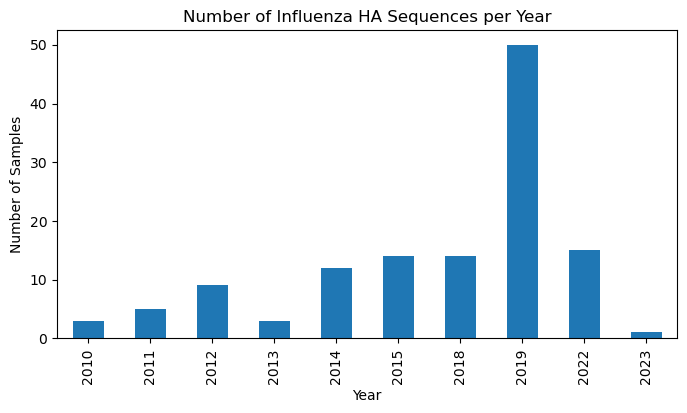

In [84]:
plt.figure(figsize=(8,4))
ohe_yr["Year"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of Samples")
plt.title("Number of Influenza HA Sequences per Year")
plt.show()


In [87]:
X_flat = ohe_yr.drop(columns=["Year"]).values.astype("float32")
years  = ohe_yr["Year"].to_numpy() 
num_seq, features = X_flat.shape

In [89]:
unique_positions = sorted({col.split('_')[0] for col in ohe_yr.drop(columns=["Year"]).columns})
seq_length = len(unique_positions)   
num_amino_acids = features // seq_length  

In [91]:
X = X_flat.reshape(num_seq, seq_length, num_amino_acids)

In [93]:
N, L, C = X.shape
S = X.sum(axis=2)
X_fixed = np.zeros((N, L, C + 1), dtype=X.dtype)
X_fixed[:, :, :C] = X


In [95]:
unk_mask = (S == 0.0)        
X_fixed[unk_mask, C] = 1.0 

X = X_fixed
UNK_IDX = C             
print("X with UNK:", X.shape)
print("One-hot OK:", np.allclose(X.sum(axis=2), 1.0))
print("UNK positions:", int(unk_mask.sum()))

X with UNK: (126, 581, 22)
One-hot OK: True
UNK positions: 3


In [97]:

X_in  = X[:, :-1, :]  
y_out = X[:,  1:, :] 


train_mask = years <= 2018
test_mask  = years >  2018

X_train_full = X_in[train_mask]
y_train_full = y_out[train_mask]

X_test = X_in[test_mask]
y_test = y_out[test_mask]

print("Train sequences:", X_train_full.shape[0])
print("Test sequences :", X_test.shape[0])

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1, random_state=42, shuffle=True
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train sequences: 60
Test sequences : 66
Train: (54, 580, 22) Val: (6, 580, 22) Test: (66, 580, 22)


In [99]:
def make_weights(y):
    return (y[..., UNK_IDX] == 0).astype("float32")

w_train = make_weights(y_train)
w_val   = make_weights(y_val)
w_test  = make_weights(y_test)

print("w_train:", w_train.shape)
print("UNK in train:", int((w_train == 0).sum()))

w_train: (54, 580)
UNK in train: 3


In [101]:

L_seq = X_train.shape[1]   
C_ch  = X_train.shape[2]

model = Sequential([
    Input(shape=(L_seq, C_ch)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(C_ch, activation='softmax'))
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
early_stop = EarlyStopping(
    monitor='val_loss',   
    patience=7,                          
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    sample_weight=w_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val, w_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.0513 - loss: 3.0902 - val_accuracy: 0.0641 - val_loss: 3.0812
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step - accuracy: 0.0708 - loss: 3.0793 - val_accuracy: 0.0767 - val_loss: 3.0698
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step - accuracy: 0.0825 - loss: 3.0670 - val_accuracy: 0.0739 - val_loss: 3.0553
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 754ms/step - accuracy: 0.0851 - loss: 3.0510 - val_accuracy: 0.0796 - val_loss: 3.0324
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - accuracy: 0.0833 - loss: 3.0252 - val_accuracy: 0.0928 - val_loss: 2.9884
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step - accuracy: 0.0823 - loss: 2.9996 - val_accuracy: 0.0879 - val_loss: 2.9801
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step - accuracy: 0.0847 - loss: 2.9822 - val_accuracy: 0.0813 - val_loss: 2.9635
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step - accuracy: 0.0878 - loss: 2.9675 - val_accuracy: 0.0825 - val

In [105]:
test_loss, test_acc = model.evaluate(
    X_test, y_test,
    sample_weight=w_test,
    verbose=0
)
perplexity = np.exp(test_loss)

print(f"Test accuracy : {test_acc:.4f}")
print(f"Test loss     : {test_loss:.4f}")
print(f"Test perplexity: {perplexity:.2f}")

Test accuracy : 0.3228
Test loss     : 2.0442
Test perplexity: 7.72


In [107]:
y_pred = model.predict(X_test, verbose=0)


In [109]:
amino_acid = ['A','C','D','E','F','G','H','I','K','L',
              'M','N','P','Q','R','S','T','V','W','Y','-','UNK']

true_idx = np.argmax(y_test, axis=-1)   
pred_idx = np.argmax(y_pred, axis=-1)

def decode_idx(row):
    return "".join(amino_acid[i] for i in row)

for i in range(3):
    print(f"--- Test {i+1} ---")
    print("TRUE:", decode_idx(true_idx[i]))
    print("\nPRED:", decode_idx(pred_idx[i]))
    print()



--- Test 1 ---
TRUE: KTIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATELVQNSSIGKICDS-PHQILDGGNCTLIDALLGDPQCDGVQN-KEWDLFVERS-RANSNCYPYDVPDYASLRSLVASSGTLEFK---NESFNWTGV-KQNGTSSACKRGSSSSFFSRLNWLTHL--NNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQISLFAQSSGRITVSTKRSQQAVIPNIGSRPRIRDISSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIR-NGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYKDWILWI-SFAMSCFLLCIALLGFIMWACQKGNIRCNICI

PRED: NILLLLLLLLLLLLLLLLLNNTLTTLLLLLVVHHPPPGTTTTTTTTTTITVTVVVVVVNNSSSSSIIIIIIIQIDDLLLLLLLLLLLDDCDDDFFQKKKKKKKKKKKYYYYSSYYYYYYYYYYYLSSSSSSSSSSSLF---------GGGFGTTSSSSSSSSSSSSSSSSSSSLLLLLL-----LLNLLLPLNNNNNNNNTGGGGVHHHHHHHDDDDIIQQISSSSSSSTTIIIIIIIIIIIRRRRRRIIIIIIIIIIIIIILLLLLLLLLLLIIGGGGGGGKKKKSSSSSSSSSSSSKSKSISSSPPPNNNNPNNNNNNNNNRRRYYYYYYYVKKKLLLLLLAANNMP--------GGGGGAGGGGGGGGGGGGGGGWGGHQQQQGGGGG

In [113]:
test = 61
print("TRUE:\n", decode_idx(true_idx[test]))
print("\nPRED:\n",decode_idx(pred_idx[test]))

TRUE:
 KTIIALSCILCQVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDS-PHQILDGENCTLIDALLGDPQCDGFQN-KKWDLFVERN-KAYSNCYPYDVPDYASLRSLVASSGTLEFN---NESFNWAGV-TQNGTSSSCIRGSKSSFFSRLNWLTHL--NSKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQISLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIR-SGKSSVMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPER----QTRGIFGAIAGFIENGWEGLVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACMGSIRNGTYDHNVYRDEALNNRFQIKGVELKSGYKDWILWI-SFAISCFLLCVVLLGFIMWACQKGNIRCNICI

PRED:
 NILLLLLLLLLLLLLLLLLNNLLLLLLLLLLHHHPPGKKKKKTTTTTTTTVTVVVVVVENGGGGIIDPPPPQQDDDDDDDDLDDLLLDDFDDDFFKKKKKKKKEEEASSSSSSYYYYYYYYYYYSSLSSSSSSSSSEF-------F-GGGTTTGGGIISSSSSSSSSSSSSLLLLLLLL----NLLNLNPPPNNNNNNKKKKGGGVHHHHDDDDQQQAAAAASSRSRRSRQQQQIIIIIIIRRRIRIIIIIIIIIIIIIIIILLLLLLLLNIIIIRRGGGRKKKKSSSSSSSSSSSSSSSSSSSSSPPPNNNNPNNNNNNNNNRRRYYYYYYYVKKKLLLLLLANNNNP--------IGGGGAGGGGGGGGGGGGGGGWGHHQQQQGGGGAAAAAAAAAAAAII

In [115]:
years_train = years[train_mask]
years_test  = years[test_mask]

print("Unique years in test:", np.unique(years_test))


Unique years in test: [2019 2022 2023]


In [117]:
yr = 2019
indices_yr = np.where(years_test == yr)[0]
print("Number of test sequences from 2023:", len(indices_yr))

#fist 2 data from selected year
chosen = indices_yr[:2]

for idx in chosen:
    print(f"--- {yr} Sample (test index {idx}) ---")
    print("Year:", years_test[idx])
    print("TRUE:", decode_idx(true_idx[idx]))
    print("\nPRED:", decode_idx(pred_idx[idx]))
    print()


Number of test sequences from 2023: 50
--- 2019 Sample (test index 16) ---
Year: 2019
TRUE: KTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGEICDS-PHQILDGGNCTLIDALLGDPQCDGFQN-KKWDLFVERS-RAYSNCYPYDVPDYASLRSLVASSGTLEFK---NESFNWAGV-TQNGKSSACIRGSSSSFFSRLNWLTHL--NYTYPALNVTMPNKEQFDKLYIWGVHHPGTDKDQIFLYAQSSGRITVSTKRSQQAVIPNIGSRPRIRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIQ-SGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEK----QTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGIELKSGYKDWILWI-SFAISCFLLCVALLGFIMWACQKGNIRCNICI

PRED: NILLLLLLLLLLLLLLLLLNNTLTTLLLLLLVHHPPGGTTTTTTTTTTITVVNVVVVVNNSSSSSIIIIIPQQDDDLLLLLLLLLLLDDNNNDFFQKKKKKKKLYYYYYYYYYYYYYYYYYYYSLLLSSSSSSSSLE-------NNNGGGTTTGGGSSSSSSSSSSSSSSLLLLLLLLL-----LPNPPPPPPNNNNNNKKNGGGVGHHHDDDDQQQQQAAASSRSSSSTSSSQIIIIIIIRRRRRRRRIIIIIIIIIIIIIIDILLLILLILIIIGGGGRRKKKKKSSSSSSSSSSSKSKSSSSSPPPNNNNPNNNNNN

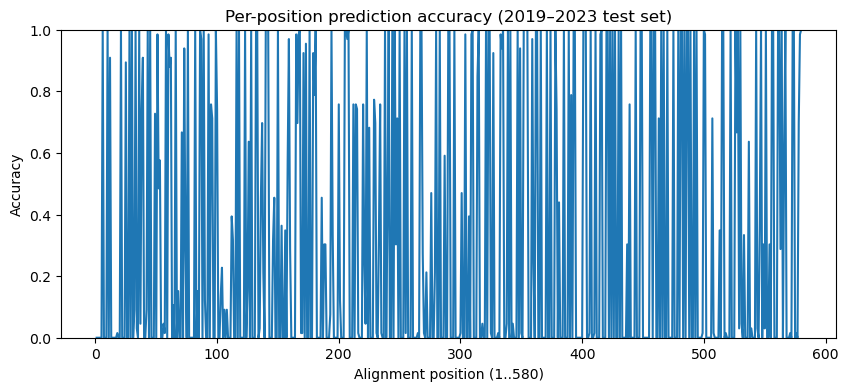

In [119]:
UNK_IDX = amino_acid.index('UNK')
mask = (true_idx != UNK_IDX)

correct = (true_idx == pred_idx) & mask
pos_acc = correct.sum(axis=0) / mask.sum(axis=0)   # (580,)

seq_length = pos_acc.shape[0]


plt.figure(figsize=(10,4))
plt.plot(range(1, seq_length+1), pos_acc)
plt.xlabel("Alignment position (1..580)")
plt.ylabel("Accuracy")
plt.title("Per-position prediction accuracy (2019–2023 test set)")
plt.ylim(0, 1)
plt.show()


In [121]:
L = pos_acc.shape[0]

positions = np.arange(1, L+1)

# sort indices by accuracy
sorted_idx = np.argsort(pos_acc)   # ascending


worst_k = 10
worst_positions = positions[sorted_idx[:worst_k]]
worst_accs = pos_acc[sorted_idx[:worst_k]]

print("Worst positions:")
for p, a in zip(worst_positions, worst_accs):
    print(f"  pos {p:3d}: accuracy={a:.3f}")


best_k = 10
best_positions = positions[sorted_idx[-best_k:]][::-1]
best_accs = pos_acc[sorted_idx[-best_k:]][::-1]

print("\nBest positions:")
for p, a in zip(best_positions, best_accs):
    print(f"  pos {p:3d}: accuracy={a:.3f}")


Worst positions:
  pos   1: accuracy=0.000
  pos 299: accuracy=0.000
  pos 298: accuracy=0.000
  pos 297: accuracy=0.000
  pos 296: accuracy=0.000
  pos 294: accuracy=0.000
  pos 293: accuracy=0.000
  pos 292: accuracy=0.000
  pos 532: accuracy=0.000
  pos 289: accuracy=0.000

Best positions:
  pos 580: accuracy=1.000
  pos 401: accuracy=1.000
  pos 393: accuracy=1.000
  pos 389: accuracy=1.000
  pos 385: accuracy=1.000
  pos 378: accuracy=1.000
  pos 374: accuracy=1.000
  pos 371: accuracy=1.000
  pos 366: accuracy=1.000
  pos 363: accuracy=1.000


In [123]:
true_flat = true_idx.flatten()
pred_flat = pred_idx.flatten()


mask = true_flat != UNK_IDX
true_flat = true_flat[mask]
pred_flat = pred_flat[mask]

labels_no_unk = amino_acid[:-1]

print(classification_report(true_flat, pred_flat,
                            target_names=labels_no_unk))




              precision    recall  f1-score   support

           A       0.35      0.25      0.29      2043
           C       0.33      0.07      0.12      1206
           D       0.33      0.37      0.35      1976
           E       0.36      0.27      0.31      1861
           F       0.64      0.17      0.26      1434
           G       0.30      0.39      0.34      2809
           H       0.32      0.37      0.34       729
           I       0.26      0.30      0.28      3382
           K       0.31      0.34      0.33      2438
           L       0.29      0.59      0.39      2837
           M       0.27      0.08      0.12       498
           N       0.32      0.36      0.34      2854
           P       0.43      0.26      0.32      1321
           Q       0.44      0.29      0.35      1611
           R       0.37      0.20      0.26      1840
           S       0.33      0.44      0.37      2837
           T       0.32      0.21      0.26      2060
           V       0.37    

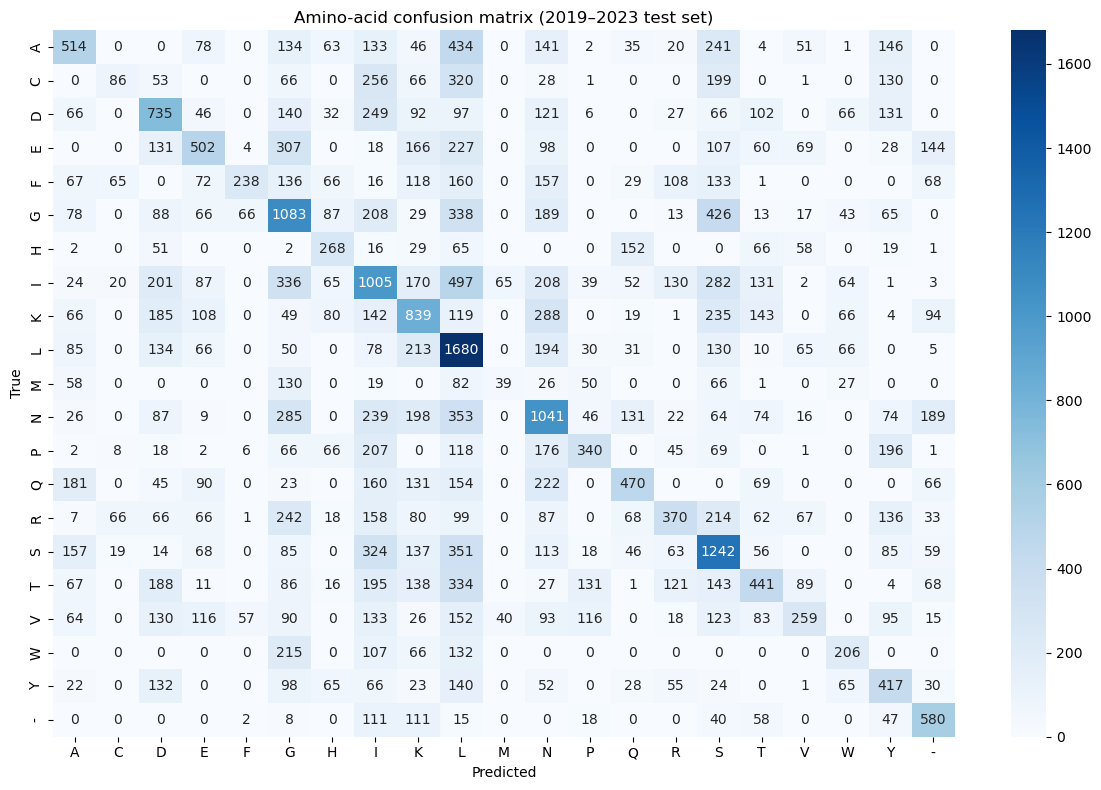

In [125]:
cm = confusion_matrix(true_flat, pred_flat, labels=range(len(labels_no_unk)))

plt.figure(figsize=(12,8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap="Blues",
            xticklabels=labels_no_unk,
            yticklabels=labels_no_unk)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Amino-acid confusion matrix (2019–2023 test set)")
plt.tight_layout()
plt.show()